# Embed, Encode and Predict

In [8]:
from __future__ import division, print_function
from keras.layers import Input
from keras.layers.core import Dense, Dropout
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import GRU
from keras.layers.pooling import GlobalMaxPooling1D
from keras.layers.wrappers import TimeDistributed, Bidirectional
from keras.models import Model
from keras.optimizers import SGD
from keras.utils import to_categorical
from sklearn.datasets import fetch_20newsgroups
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from keras.utils import plot_model
import logging
import matplotlib.pyplot as plt
import nltk
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [13]:
DATA_DIR = "../data"

VOCAB_FILE = os.path.join(DATA_DIR, "ng-vocab.tsv")
MIN_OCCURS = 5

GLOVE_FILE = os.path.join(DATA_DIR, "glove.840B.300d.txt")

# covers about 95% of input data
MAX_SENTS = 40 # maximum number of sentences per document
MAX_WORDS = 60 # maximum number of words per sentence

WORD_EMBED_SIZE = 300
SENT_EMBED_SIZE = 100
DOC_EMBED_SIZE = 50
NUM_CLASSES = 20

BATCH_SIZE = 64
NUM_EPOCHS = 10

logging.basicConfig()

## Load Vocabulary

In [14]:
word2id = {"PAD": 0, "UNK": 1}
fvocab = open(VOCAB_FILE, "r")
for i, line in enumerate(fvocab):
    word, count = line.strip().split("\t")
    if int(count) <= MIN_OCCURS:
        break
    word2id[word] = i
fvocab.close()
id2word = {v:k for k, v in word2id.items()}
vocab_size = len(word2id)
print("vocab_size: {:d}".format(vocab_size))
print(word2id)

vocab_size: 40683
{'mintaka.lcs.mit.edu': 25525, '1993apr26.193801.12416': 38876, 'deck': 7377, 'gripe': 15085, 'existed': 3786, '217': 8543, 'relayed': 33343, 'evan': 15417, 'accomodation': 17766, 'european': 1628, 'teac': 27533, 'manta': 9888, 'mueller': 12542, 'favorite': 3154, 'likelyhood': 29222, 'garyg': 31665, 'lehtori.cc.tut.fi': 17860, '*chose*': 29214, 'swallow': 10849, '64kb': 34919, '-i': 10416, 'lam': 17184, '82238': 29685, 'azw': 13893, 'cover-up': 17706, 'phonograph': 35227, '1993apr17.023017.17301': 30820, 'election': 5034, '24e': 4231, 'u28037': 8006, 'up..': 28691, 'situations': 2496, 'ton': 10995, 'zbiciak': 34654, 'photographic': 13692, 'buried': 6564, 'henceforth': 25585, '1=1': 23646, '1939': 14247, 'relaxation': 20138, 'taybh': 34082, 'laughs': 40161, 'speciality': 40361, 'whore': 20366, 'exert': 25767, '79': 3152, 'pa': 1702, "'69": 20487, 'beats': 6049, 'aerobraking': 31230, 'shelley.u.washington.edu': 10011, '1210': 34737, 'math.ilstu.edu': 38503, 'hateful': 1

## Load GloVe Embeddings

In [15]:
E = np.zeros((vocab_size, WORD_EMBED_SIZE))
E[1] = np.random.random(WORD_EMBED_SIZE)
fglove = open(GLOVE_FILE, "rb")
for line in fglove:
  try:
    cols = line.decode('utf-8').strip().split(" ")
    #print('???',cols[0])
    word = cols[0]
    #print(word2id)
    if not word in word2id:
        continue
    vec = np.array([float(x) for x in cols[1:]])
    idx = word2id[word]
    
    E[idx] = vec
    #print(idx, ' | ', vec)
  except Exception as e:
    print('gg',e)
print('??????????')
fglove.close()
print(E.shape)

??????????
(40683, 300)


## Compute Document Vectors

In [16]:
ng_data = fetch_20newsgroups(subset='all',
                             data_home=DATA_DIR,
                             shuffle=True, 
                             random_state=42)
num_docs = len(ng_data.data)
print(num_docs)

18846


In [17]:
def pad_or_truncate(xs, maxlen):
    if len(xs) > maxlen:
        xs = xs[len(xs) - maxlen:]
    elif len(xs) < maxlen:
        xs = ["PAD"] * (maxlen - len(xs)) + xs
    return xs

xs = ["The", "cat", "fought", "like", "a", "mouse"]
print(pad_or_truncate(xs, 3))
print(pad_or_truncate(xs, 7))

['like', 'a', 'mouse']
['PAD', 'The', 'cat', 'fought', 'like', 'a', 'mouse']


In [18]:
X = np.zeros((num_docs, MAX_SENTS, MAX_WORDS))
for docid in range(num_docs):
    text = ng_data.data[docid]
    sents = pad_or_truncate(nltk.sent_tokenize(text), MAX_SENTS)
    for sid, sent in enumerate(sents):
        words = nltk.word_tokenize(sent)
        words = pad_or_truncate(words, MAX_WORDS)
        for wid, word in enumerate(words):
            try:
                word_id = word2id[word]
            except KeyError:
                word_id = word2id["UNK"]
            X[docid, sid, wid] = word_id
print(X.shape)

(18846, 40, 60)


In [19]:
y = ng_data.target
Y = to_categorical(y, num_classes=NUM_CLASSES)
print(Y.shape)

(18846, 20)


In [20]:
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, train_size=0.7)
print(Xtrain.shape, Ytrain.shape, Xtest.shape, Ytest.shape)

(13192, 40, 60) (13192, 20) (5654, 40, 60) (5654, 20)


## Define Network

__Note:__ 

Setting the embedding weights and making the layer trainable (so backprop can update the weights) results in much better performance (0.788 accuracy on test set, 0.9831 on training set) than making the layer non-trainable (0.706 accuracy on test set, 0.7827 on training set). One possible reason is that making the embedding layer non-trainable drops the number of trainable parameters from 12,540,970 to 321,970 (about 10x our base embed-predict BoW model with 32,120 parameters).

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 60)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 60, 300)           12204900  
_________________________________________________________________
bidirectional_1 (Bidirection (None, 200)               240600    
Total params: 12,445,500
Trainable params: 12,445,500
Non-trainable params: 0
_________________________________________________________________


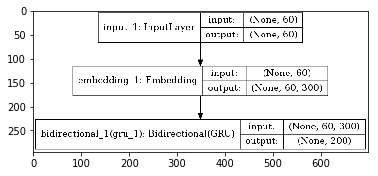

In [21]:
sent_inputs = Input(shape=(MAX_WORDS,), dtype="int32")
sent_emb = Embedding(input_dim=vocab_size,
                     output_dim=WORD_EMBED_SIZE,
                     weights=[E])(sent_inputs)
sent_enc = Bidirectional(GRU(SENT_EMBED_SIZE))(sent_emb)

sent_encoder = Model(inputs=sent_inputs, outputs=sent_enc)
plot_model(sent_encoder,to_file='sent_encoder.png',show_shapes=True, show_layer_names=True)
sent_encoder.summary()

img=mpimg.imread('sent_encoder.png')
imgplot = plt.imshow(img)
plt.show()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 40, 60)            0         
_________________________________________________________________
time_distributed_9 (TimeDist (None, 40, 200)           12445500  
_________________________________________________________________
bidirectional_8 (Bidirection (None, 100)               75300     
_________________________________________________________________
dropout_13 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 50)                5050      
_________________________________________________________________
dropout_14 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_21 (Dense)             (None, 20)                1020      
Total para

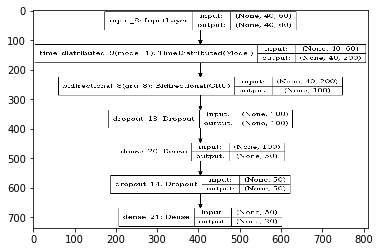

In [28]:
doc_inputs = Input(shape=(MAX_SENTS, MAX_WORDS), dtype="int32")
doc_emb = TimeDistributed(sent_encoder)(doc_inputs)
doc_enc = Bidirectional(GRU(DOC_EMBED_SIZE))(doc_emb)

fc1_dropout = Dropout(0.2)(doc_enc)
fc1 = Dense(50, activation="relu")(fc1_dropout)
fc2_dropout = Dropout(0.2)(fc1)
outputs = Dense(NUM_CLASSES, activation="softmax")(fc2_dropout)

model = Model(inputs=doc_inputs, outputs=outputs)
plot_model(model,to_file='model_plot.png',show_shapes=True, show_layer_names=True)
model.summary()
img=mpimg.imread('model_plot.png')
imgplot = plt.imshow(img, interpolation='nearest', aspect='auto')
#plt.figure(figsize=(1,7))
plt.show()

In [ ]:
model.compile(optimizer="adam", loss="categorical_crossentropy",
              metrics=["accuracy"])

In [ ]:
history = model.fit(Xtrain, Ytrain, batch_size=BATCH_SIZE,
                   epochs=NUM_EPOCHS, validation_split=0.1)

In [ ]:
plt.subplot(211)
plt.title("accuracy")
plt.plot(history.history["acc"], color="r", label="train")
plt.plot(history.history["val_acc"], color="b", label="val")
plt.legend(loc="best")

plt.subplot(212)
plt.title("loss")
plt.plot(history.history["loss"], color="r", label="train")
plt.plot(history.history["val_loss"], color="b", label="val")
plt.legend(loc="best")

plt.tight_layout()
plt.show()

## Evaluate Network

In [ ]:
np.set_printoptions(linewidth=120)
Ytest_ = model.predict(Xtest)
ytest_ = np.argmax(Ytest_, axis=1)
ytest = np.argmax(Ytest, axis=1)
print("accuracy score: {:.3f}".format(accuracy_score(ytest, ytest_)))
print("\nconfusion matrix\n")
print(confusion_matrix(ytest, ytest_))

In [ ]:
from keras.layers import Dense, Flatten, Input
from keras.layers.embeddings import Embedding
from keras.models import Model
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import one_hot
# define documents
docs = ['Well done!',
        'Good work',
        'Great effort',
        'nice work',
        'Excellent!',
        'Weak',
        'Poor effort!',
        'not good',
        'poor work',
        'Could have done better.']
# define class labels
labels = [1, 1, 1, 1, 1, 0, 0, 0, 0, 0]
# integer encode the documents
vocab_size = 50
encoded_docs = [one_hot(d, vocab_size) for d in docs]
print(encoded_docs)
# pad documents to a max length of 4 words
max_length = 4
padded_docs = pad_sequences(encoded_docs, maxlen=max_length, padding='post')
print(padded_docs)
# define the model
input = Input(shape=(4, ))
x = Embedding(vocab_size, 8, input_length=max_length)(input)
e = Model(inputs=input, output=x)
x = Flatten()(x)
f = Model(inputs=input, output=x)
x = Dense(1, activation='sigmoid')(x)
model = Model(inputs=input, outputs=x)
# compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
# summarize the model
print(model.summary())
# fit the model
model.fit(padded_docs, labels, epochs=50, verbose=0)
print(e.predict(padded_docs).shape)
print(f.predict(padded_docs).shape)
print(model.predict(padded_docs))
# evaluate the model
loss, accuracy = model.evaluate(padded_docs, labels, verbose=0)
print('Accuracy: %f' % (accuracy * 100))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 5)                 140       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 6         
Total params: 146
Trainable params: 146
Non-trainable params: 0
_________________________________________________________________
None


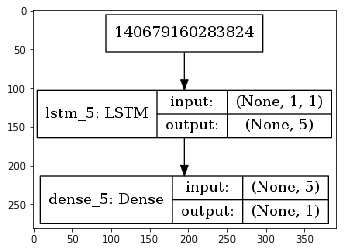

In [9]:
from numpy import array
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
# prepare sequence
length = 5
seq = array([i/float(length) for i in range(length)])
X = seq.reshape(len(seq), 1, 1)
y = seq.reshape(len(seq), 1)
# define LSTM configuration
n_neurons = length
n_batch = length
n_epoch = 1000
# create LSTM
model = Sequential()
model.add(LSTM(n_neurons, input_shape=(1, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
print(model.summary())
# train LSTM
'''
model.fit(X, y, epochs=n_epoch, batch_size=n_batch, verbose=2)
# evaluate
result = model.predict(X, batch_size=n_batch, verbose=0)

for value in result:
	print('%.1f' % value)
'''
plot_model(model,to_file='1_1_lstm_nodist_dense.png',show_shapes=True, show_layer_names=True)

img=mpimg.imread('1_1_lstm_nodist_dense.png')
imgplot = plt.imshow(img)
plt.show()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 5)                 140       
_________________________________________________________________
dense_6 (Dense)              (None, 5)                 30        
Total params: 170
Trainable params: 170
Non-trainable params: 0
_________________________________________________________________
None


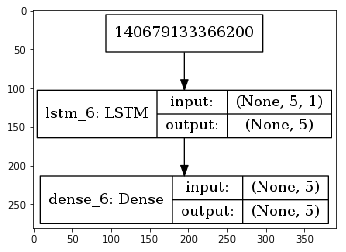

In [10]:
from numpy import array
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
# prepare sequence
length = 5
seq = array([i/float(length) for i in range(length)])
X = seq.reshape(1, length, 1)
y = seq.reshape(1, length)
# define LSTM configuration
n_neurons = length
n_batch = 1
n_epoch = 500
# create LSTM
model = Sequential()
model.add(LSTM(n_neurons, input_shape=(length, 1)))
model.add(Dense(length))
model.compile(loss='mean_squared_error', optimizer='adam')
print(model.summary())
'''
# train LSTM
model.fit(X, y, epochs=n_epoch, batch_size=n_batch, verbose=2)
# evaluate
result = model.predict(X, batch_size=n_batch, verbose=0)
for value in result[0,:]:
	print('%.1f' % value)
'''
plot_model(model,to_file='m_1_lstm_nodist_dense.png',show_shapes=True, show_layer_names=True)
img=mpimg.imread('m_1_lstm_nodist_dense.png')
imgplot = plt.imshow(img)
plt.show()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 5, 5)              140       
_________________________________________________________________
time_distributed_2 (TimeDist (None, 5, 1)              6         
Total params: 146
Trainable params: 146
Non-trainable params: 0
_________________________________________________________________
None


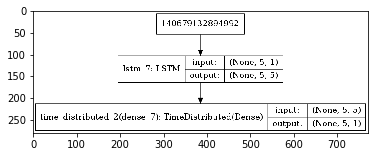

In [11]:
from numpy import array
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import TimeDistributed
from keras.layers import LSTM
# prepare sequence
length = 5
seq = array([i/float(length) for i in range(length)])
X = seq.reshape(1, length, 1)
y = seq.reshape(1, length, 1)
# define LSTM configuration
n_neurons = length
n_batch = 1
n_epoch = 1000
# create LSTM
model = Sequential()
model.add(LSTM(n_neurons, input_shape=(length, 1), return_sequences=True))
model.add(TimeDistributed(Dense(1)))
model.compile(loss='mean_squared_error', optimizer='adam')
print(model.summary())
'''
# train LSTM
model.fit(X, y, epochs=n_epoch, batch_size=n_batch, verbose=2)
# evaluate
result = model.predict(X, batch_size=n_batch, verbose=0)
for value in result[0,:,0]:
	print('%.1f' % value)
'''
plot_model(model,to_file='m_m_lstm_dist_dense.png',show_shapes=True, show_layer_names=True)
img=mpimg.imread('m_m_lstm_dist_dense.png')
imgplot = plt.imshow(img)
plt.show()